## Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

import zipfile
import os # Used to interact with the file system

## Reading in the base files

In [2]:
# base files
vgsales = pd.read_csv('vgsales.csv')
vgsales['Name'] = vgsales['Name'].str.lower()

# cleaning the esrb csv -- deleting whitespace, renaming columns, eliminating duplicate rows
esrb = pd.read_csv('esrb_ratings_cleaned.csv')
esrb.rename({'Column1.2':'Content_Descriptor', 'Column1.3':'Name', 'Column1.4':'Platform', 'Column1.5':'ESRB_Rating'}, axis = 1, inplace = True)
esrb['Content_Descriptor'] = esrb['Content_Descriptor'].str.strip()
esrb['Platform'] = esrb['Platform'].str.strip()
esrb['Name'] = esrb['Name'].str.strip()
esrb['Name'] = esrb['Name'].str.lower()
esrb.drop('Column1.1', axis = 1, inplace = True)
esrb.drop_duplicates(inplace = True)

# vgsales.loc[vgsales['Name'] == 'Dark Souls']
# vgsales['Name'].unique()

In [3]:
# one hot encode the esrb table to include all content descriptors
dummies_descriptors = pd.get_dummies(esrb.Content_Descriptor)
dummies_combined = pd.concat([esrb, dummies_descriptors], axis = 1)
dummies_grouped = dummies_combined.groupby(['Name', 'Platform', 'ESRB_Rating']).agg('sum')
dummies_grouped.reset_index(inplace = True)

# len(dummies_grouped)

In [4]:
# remapping platform names so that they match between the esrb table and the vgsales table
platform_map = {'Wii U' : 'WiiU', 'Wii' : 'Wii', 'Nintendo 3DS' : '3DS', 'Game Boy Advance' : 'GBA', 'Nintendo DS' : 'DS', 'Windows PC' : 'PC', 'PlayStation 4' : 'PS4', 'Xbox 360' : 'X360', 'PS Vita' : 'PSV', 'Xbox One' : 'XOne', 'PlayStation 3' : 'PS3', 'PlayStation 2' : 'PS2', 'PSP' : 'PSP', 'Xbox' : 'XB', 'Super Nintendo' : 'SNES', 'Nintendo' : 'NES', 'Game Boy' : 'GB', 'PlayStation/PS one' : 'PS', 'Nintendo 64' : 'N64', 'GameCube' : 'GC', 'Game Gear' : 'GG', 'Dreamcast' : 'DC', 'Sega Saturn' : 'SAT', 'Genesis' : 'GEN'}
dummies_grouped['Platform'] = dummies_grouped['Platform'].replace(platform_map)
#dummies_grouped.head()

In [5]:
# joining the two tables
vgsales_combined = vgsales.merge(dummies_grouped, on = ['Name', 'Platform'], how = 'inner')

# len(vgsales_combined)
# len(vgsales_combined['Name'].unique()) # length of unique game names
# vgsales_combined.loc[vgsales_combined['Name'] == 'Dark Souls'] #check if we can get multiple rows with different platforms

In [6]:
vgsales_combined.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,...,Suggestive Themes,Suitable for Mature Users,Tobacco Reference,Use of Alcohol,Use of Alcohol and Tobacco,Use of Drugs,Use of Drugs and Alcohol,Use of Tobacco,Violence,Violent References
0,1,wii sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,...,0,0,0,0,0,0,0,0,0,0
1,3,mario kart wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,...,0,0,0,0,0,0,0,0,0,0
2,4,wii sports resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,...,0,0,0,0,0,0,0,0,0,0
3,7,new super mario bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,...,0,0,0,0,0,0,0,0,0,0
4,8,wii play,Wii,2006.0,Misc,Nintendo,14.03,9.20,2.93,2.85,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [7]:
def make_global_plots(df, group):
    """
    Generates a plot of percentage of sales, grouped by [group]
    
    Inputs:
    -------
    df: pd.DataFrame
        the dataframe to draw groups from
    group: pd.Series
        the column of interest
        
    Outputs:
    --------
    a graph with the group on the x axis and the percentage of sales (scaled globally) on the y axis, 
    """
    columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    vg_group = df.groupby([group], as_index = False).agg('sum')
    for c in columns:
        vg_group[c + '_percentage_global'] = vg_group[c] / vg_group['Global_Sales'] * 100

    vg_group = vg_group[[group, 'NA_Sales_percentage_global', 'EU_Sales_percentage_global', 'JP_Sales_percentage_global', 'Other_Sales_percentage_global']]
    vg_group = vg_group.rename(columns={'NA_Sales_percentage_global' : 'NA', 'EU_Sales_percentage_global' : 'EU', 'JP_Sales_percentage_global' : 'JP', 'Other_Sales_percentage_global' : 'Other'})
    vg_group = vg_group.melt(id_vars=group, value_vars=['NA', 'EU', 'JP', 'Other'], var_name='Region', value_name='Percentage_sold_global')

    plt.figure(figsize=(12, 12))
    sns.barplot(x=group, y='Percentage_sold_global', data=vg_group, hue='Region', palette='viridis')
    plt.xlabel(group)
    plt.ylabel('Percentage of copies sold globally')
    plt.title('Percentage of Copies Sold for Each ' + group + ' Globally, by Region')
    plt.xticks(rotation = 45)

In [8]:
def make_region_plots(df, group):
    """
    Generates a plot of percentage of sales, grouped by region
    
    Inputs:
    -------
    df: pd.DataFrame
        the dataframe to draw groups from
    group: pd.Series
        the column of interest
    """
    columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    vg_group = df.groupby([group], as_index = False).agg('sum')
    for c in columns:
        vg_group[c + '_percentage_region'] = vg_group[c] / np.sum(vg_group[c]) * 100

    vg_group = vg_group[[group, 'NA_Sales_percentage_region', 'EU_Sales_percentage_region', 'JP_Sales_percentage_region', 'Other_Sales_percentage_region']]
    vg_group = vg_group.rename(columns={'NA_Sales_percentage_region' : 'NA', 'EU_Sales_percentage_region' : 'EU', 'JP_Sales_percentage_region' : 'JP', 'Other_Sales_percentage_region' : 'Other'})
    vg_group = vg_group.melt(id_vars=group, value_vars=['NA', 'EU', 'JP', 'Other'], var_name='Region', value_name='Percentage_sold_region')

    plt.figure(figsize=(12, 12))
    sns.barplot(x='Region', y='Percentage_sold_region', data=vg_group, hue=group, palette='hls')
    plt.xlabel('Region')
    plt.ylabel('Percentage of copies sold in region')
    plt.title('Percentage of Copies Sold in Each Region by ' + group)
    plt.xticks(rotation = 45)

# Sales by Genre

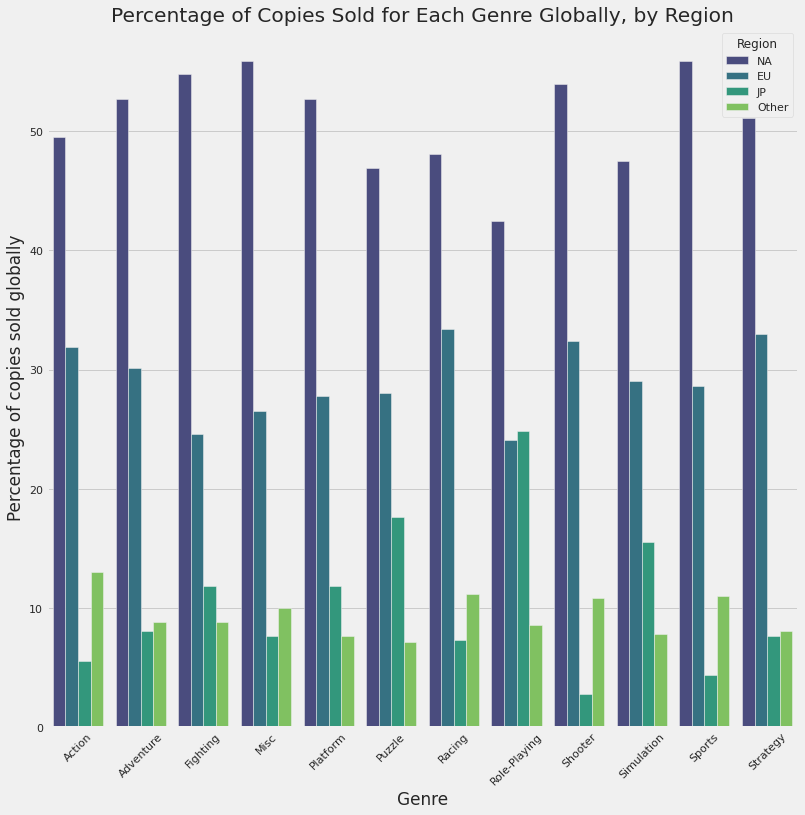

In [9]:
make_global_plots(vgsales_combined, 'Genre')

In the above graph, it seems like North America dominates video game sales across all genres, with EU following behind. The only genre that Japan buys a significant number of games from is RPGs, or role-playing games.

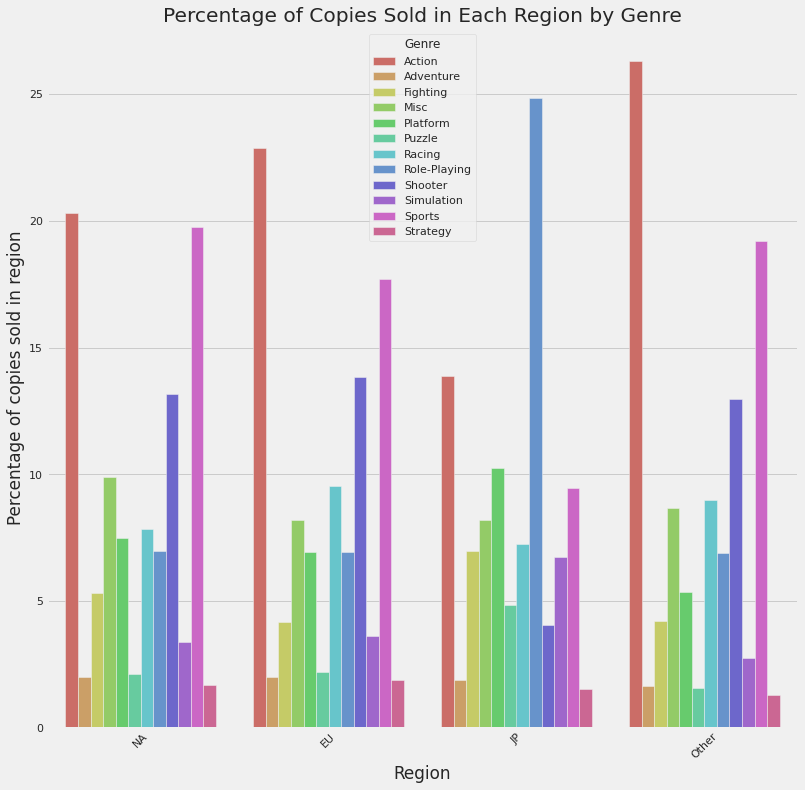

In [10]:
make_region_plots(vgsales_combined, 'Genre')

This graph is similar to the prevous one in the sense that action games, in most regions, dominate video game sales. In most regions, sports games follow closely behind as the second most popular genre.

However, in Japan, the same statement can be made where RPGs are very popular, while action follows behind. In general, the popularity of genres throughout the world is different from the popularity of genres in Japan.

# Sales by Platform

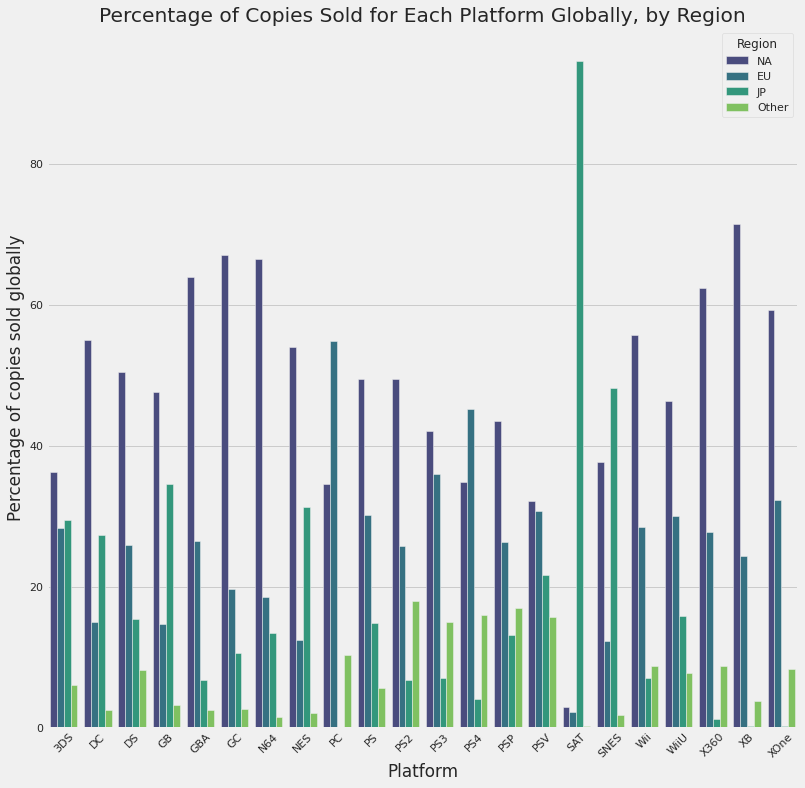

In [11]:
make_global_plots(vgsales_combined, 'Platform')

Again, it seems like North America dominates sales for most video game platforms. However, EU prefers PC and PS4 titles over anything else, and Japan has a heavy preference for the Sega Saturn and the SNES, both of which are very old consoles. In addition, they seem to avoid buying PC, XBox and XBox One titles.

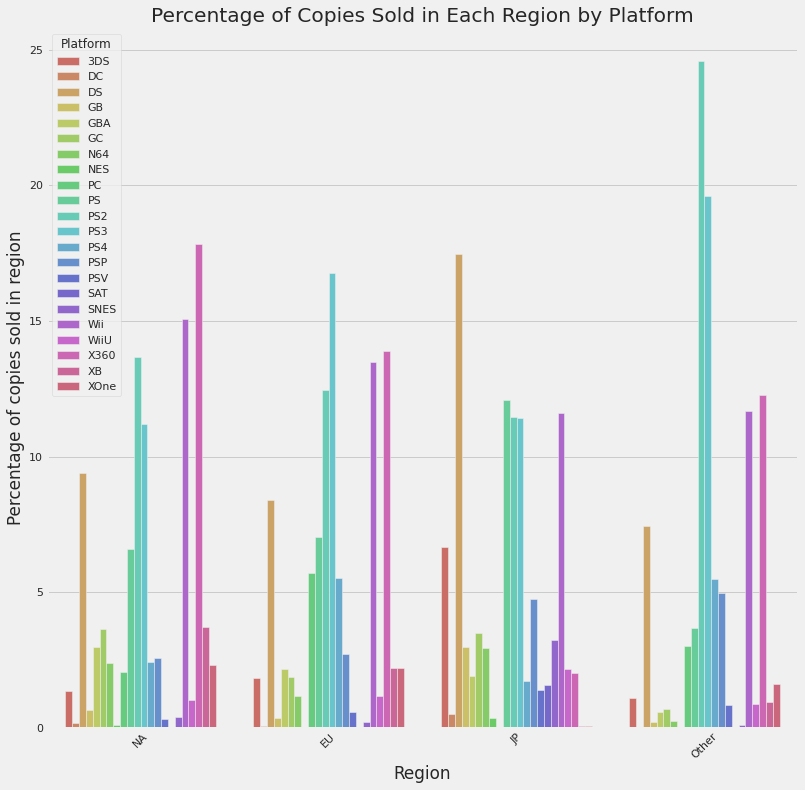

In [12]:
make_region_plots(vgsales_combined, 'Platform')

In North America, it seems like the most popular console is the XBox, followed by the SNES and PC titles. EU is fairly similar, with their top 3 also being PC, XBox, and SNES. In Japan, most people prefer the DS, although PC and SNES are also popular. In the rest of the world, PC games seem to be the most popular.

# Sales by ESRB Rating

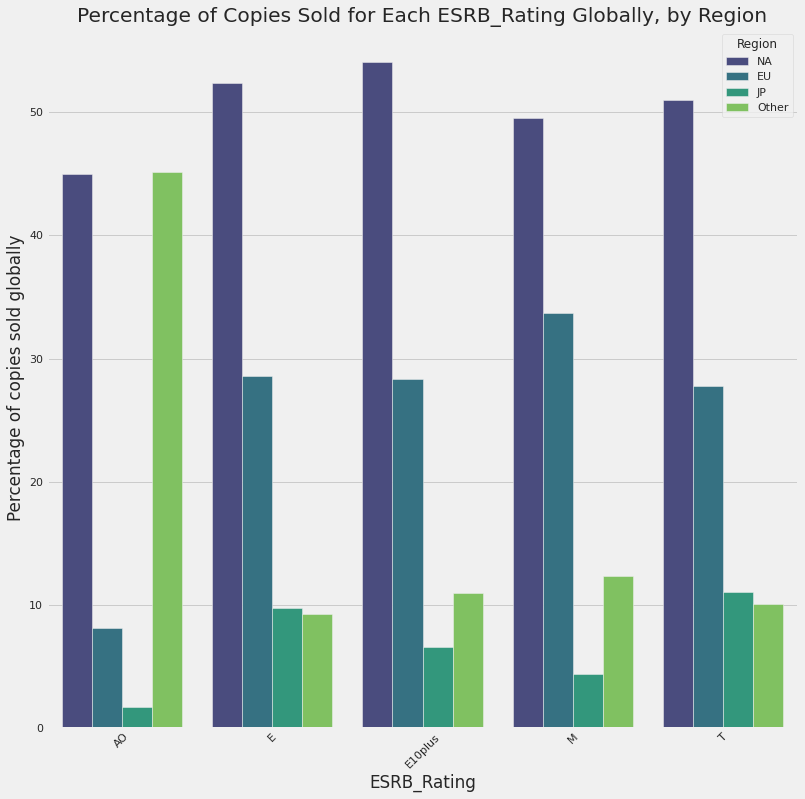

In [13]:
make_global_plots(vgsales_combined, 'ESRB_Rating')

In general, North America, again, dominates most game sales. However, in other parts of the world, AO-rated games are really popular.

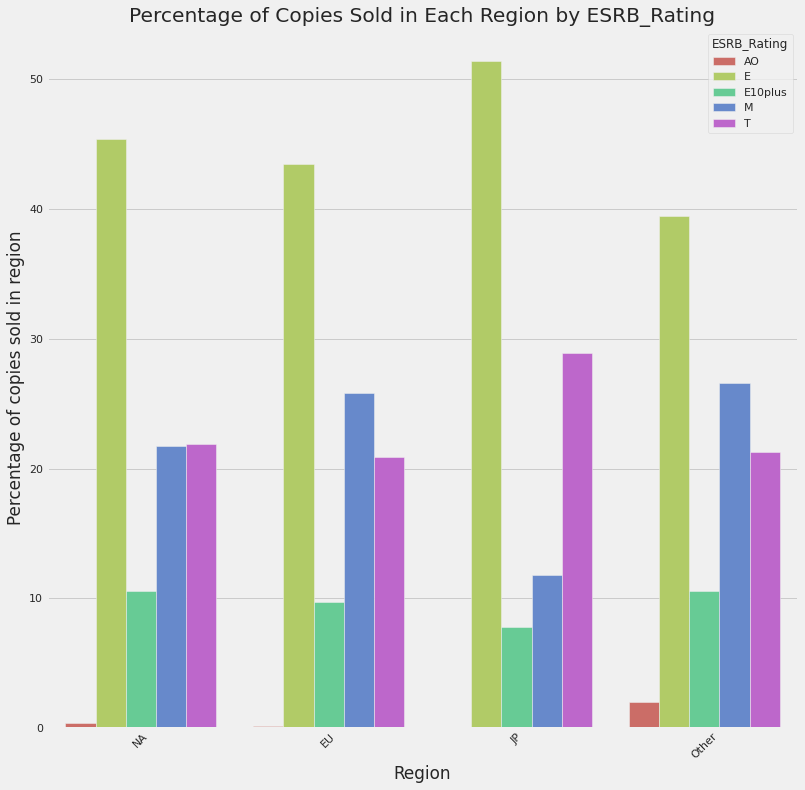

In [14]:
make_region_plots(vgsales_combined, 'ESRB_Rating')

In general, E rated games are the most popular, which makes sense since they are relevant to all audiences. It is less likely for a game to be rated as E10plus or AO, which explains why those sales are low.

Limitations to dataset:
- sales dataset only includes games with >100,000 copies sold
- once we merge with esrb, we lose ~8,000 entries, so modeling might not be representative of the wider dataset
- the sales dataset only goes up to 2016, so newer titles and consoles are not included
- more obscure platforms were discarded since we didn't know how to map each platform to its correct abbreviation
- games are not randomly selected, so some trends may appear solely because one occurence happens more often than another

# Preparation for PCA Transformation

In [15]:
# one hot encode the dataset for 'Platform' and 'ESRB_Rating'
# vgsales_combined.dropna(subset = ['Year'], axis = 0, inplace = True)
vgsales_combined_encoded = pd.get_dummies(vgsales_combined, columns=['Platform', 'ESRB_Rating'], drop_first=True)
vgsales_combined_encoded.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Alcohol Reference,Alcohol and Tobacco Reference,Animated Blood,...,Platform_SNES,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,ESRB_Rating_E,ESRB_Rating_E10plus,ESRB_Rating_M,ESRB_Rating_T
count,7958.000000,7821.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,...,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000,7958.000000
mean,7485.934908,2007.006265,0.331843,0.189607,0.054507,0.067355,0.643596,0.040211,0.011938,0.035939,...,0.002262,0.103041,0.010681,0.102036,0.055667,0.016838,0.433526,0.140739,0.146896,0.278462
std,4626.355054,4.745878,0.893521,0.628831,0.266153,0.274293,1.820243,0.196466,0.108612,0.186149,...,0.047508,0.304031,0.102802,0.302714,0.229292,0.128674,0.495593,0.347774,0.354025,0.448270
min,1.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3428.750000,2004.000000,0.050000,0.010000,0.000000,0.010000,0.080000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7268.500000,2008.000000,0.120000,0.040000,0.000000,0.020000,0.220000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11266.750000,2010.000000,0.310000,0.160000,0.000000,0.050000,0.590000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,16595.000000,2016.000000,41.490000,29.020000,6.500000,10.570000,82.740000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
np.array(vgsales_combined_encoded.columns)

array(['Rank', 'Name', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Alcohol Reference', 'Alcohol and Tobacco Reference',
       'Animated Blood', 'Animated Blood and Gore', 'Animated Violence',
       'Blood', 'Blood and Gore', 'Cartoon Violence', 'Comic Mischief',
       'Crude Humor', 'Drug Reference', 'Drug and Alcohol Reference',
       'Edutainment', 'Fantasy Violence', 'Gambling', 'Gaming',
       'Informational', 'Intense Violence', 'Language', 'Lyrics',
       'Mature Humor', 'Mature Sexual Themes', 'Mild Animated Violence',
       'Mild Blood', 'Mild Cartoon Violence', 'Mild Fantasy Violence',
       'Mild Language', 'Mild Lyrics', 'Mild Sexual Themes',
       'Mild Suggestive Themes', 'Mild Violence', 'No Descriptors',
       'Nudity', 'Partial Nudity', 'Realistic Blood',
       'Realistic Blood and Gore', 'Realistic Violence', 'Sexual Content',
       'Sexual Themes', 'Sexual Violence', 'Simulated Gambling',


In [17]:
from sklearn.preprocessing import StandardScaler
stats = ['NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Alcohol Reference', 'Alcohol and Tobacco Reference',
       'Animated Blood', 'Animated Blood and Gore', 'Animated Violence',
       'Blood', 'Blood and Gore', 'Cartoon Violence', 'Comic Mischief',
       'Crude Humor', 'Drug Reference', 'Drug and Alcohol Reference',
       'Edutainment', 'Fantasy Violence', 'Gambling', 'Gaming',
       'Informational', 'Intense Violence', 'Language', 'Lyrics',
       'Mature Humor', 'Mature Sexual Themes', 'Mild Animated Violence',
       'Mild Blood', 'Mild Cartoon Violence', 'Mild Fantasy Violence',
       'Mild Language', 'Mild Lyrics', 'Mild Sexual Themes',
       'Mild Suggestive Themes', 'Mild Violence', 'No Descriptors',
       'Nudity', 'Partial Nudity', 'Realistic Blood',
       'Realistic Blood and Gore', 'Realistic Violence', 'Sexual Content',
       'Sexual Themes', 'Sexual Violence', 'Simulated Gambling',
       'Strong Language', 'Strong Lyrics', 'Strong Sexual Content',
       'Suggestive Themes', 'Suitable for Mature Users',
       'Tobacco Reference', 'Use of Alcohol',
       'Use of Alcohol and Tobacco', 'Use of Drugs',
       'Use of Drugs and Alcohol', 'Use of Tobacco', 'Violence',
       'Violent References', 'Platform_DC', 'Platform_DS', 'Platform_GB',
       'Platform_GBA', 'Platform_GC', 'Platform_N64', 'Platform_NES',
       'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3',
       'Platform_PS4', 'Platform_PSP', 'Platform_PSV', 'Platform_SAT',
       'Platform_SNES', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne', 'ESRB_Rating_E',
       'ESRB_Rating_E10plus', 'ESRB_Rating_M', 'ESRB_Rating_T']
# Separating out the features
x = vgsales_combined_encoded.loc[:, stats].values
# Separating out the target
y = vgsales_combined_encoded.loc[:,['Genre']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [18]:
from sklearn.decomposition import PCA
#3-component PCA
pca = PCA(n_components=3)
#project data into PC space
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [19]:
finalDf = pd.concat([principalDf, vgsales_combined_encoded[['Genre']].astype(str)], axis = 1)
finalfinalDf = finalDf[0:]

In [20]:
vgsales_combined_encoded['Genre'].unique()

array(['Sports', 'Racing', 'Platform', 'Misc', 'Simulation', 'Action',
       'Puzzle', 'Shooter', 'Fighting', 'Role-Playing', 'Strategy',
       'Adventure'], dtype=object)

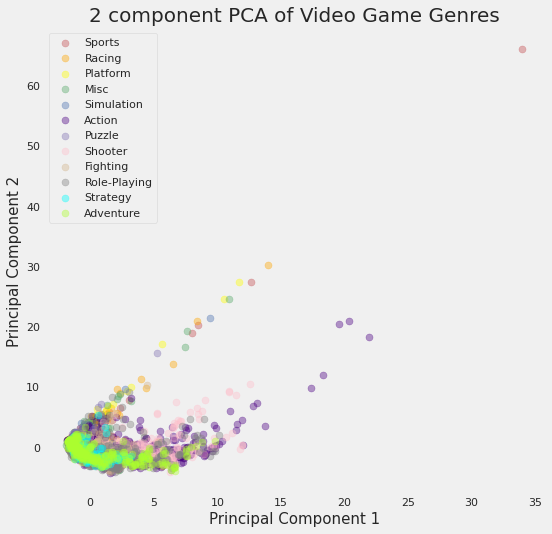

In [21]:
targets = ['Sports', 'Racing', 'Platform', 'Misc', 'Simulation', 'Action',
       'Puzzle', 'Shooter', 'Fighting', 'Role-Playing', 'Strategy',
       'Adventure']
colors = ['r', 'orange', 'yellow', 'g', 'b', 'indigo', 'm', 'pink', 'tan', 'gray', 'cyan', 'greenyellow']
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA of Video Game Genres', fontsize = 20)
for target, color in zip(targets,colors):
    indicesToKeep = finalfinalDf['Genre'] == target
    ax.scatter(finalfinalDf.loc[indicesToKeep, 'principal component 1']
               , finalfinalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.4)
ax.legend(targets)
ax.grid()

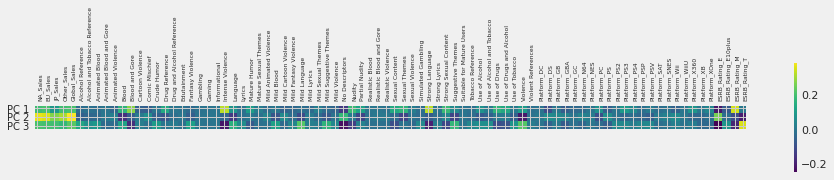

In [22]:
#making heatmap of PC coefficients
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['PC 1','PC 2','PC 3'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(stats)),stats,rotation=90,ha='left', fontsize = 6)
plt.show()# 

In [23]:
pca.explained_variance_ratio_

array([0.0584656 , 0.04699772, 0.03855558])

<BarContainer object of 84 artists>

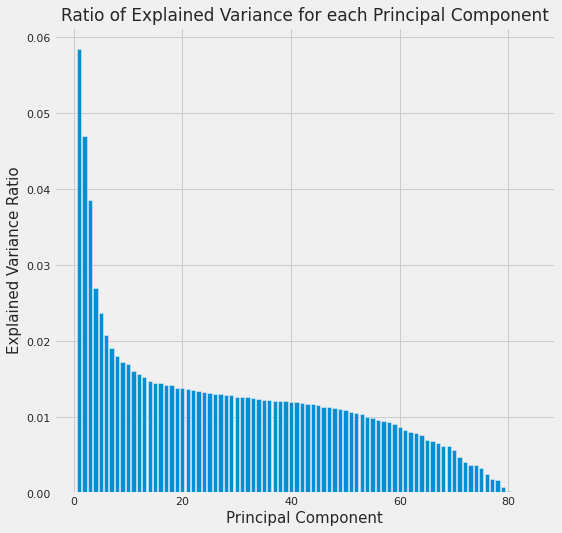

In [24]:
pca_full = PCA()
principalComponents_full = pca_full.fit_transform(x)
explained_var_ratios = pca_full.explained_variance_ratio_
var = range(1, len(explained_var_ratios) + 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_title('Ratio of Explained Variance for each Principal Component', fontsize = 17)
ax.set_xlabel('Principal Component', fontsize = 15)
ax.set_ylabel('Explained Variance Ratio', fontsize = 15)
ax.bar(var, explained_var_ratios)

# Random Forests and Gradient Boosted Forests

In [25]:
rawXdata = finalfinalDf[["principal component 1", "principal component 2"]]

Xtrain, Xtest, ytrain, ytest = train_test_split(
  rawXdata,finalfinalDf['Genre'],
  train_size = 0.75,
  random_state = 24)

In [26]:
def compute_CV_acc(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 4 models total.
    Return the average MSE of these 4 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
      
        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        error = model.score(split_X_valid, split_Y_valid)
        # END SOLUTION

        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [27]:
accuracies = []
randomForests = [RandomForestClassifier(random_state=24, max_depth = i) for i in range(10, 15)]
for r in randomForests:
    accuracies.append(compute_CV_acc(r, Xtrain, ytrain))
best_max_depth = np.argmax(accuracies) + 10 # SOLUTION
best_acc = accuracies[np.argmax(accuracies)] # SOLUTION
print(best_max_depth, best_acc)

10 0.28920911528150134


In [28]:
#Without depth limiting
randomForest = RandomForestClassifier(random_state=24)
randomForest.fit(Xtrain, ytrain)
randomForest.score(Xtest, ytest)

0.2547738693467337

In [29]:
#With depth limiting
randomForest = RandomForestClassifier(random_state=24, max_depth = 10)
randomForest.fit(Xtrain, ytrain)
randomForest.score(Xtest, ytest)

0.31206030150753766

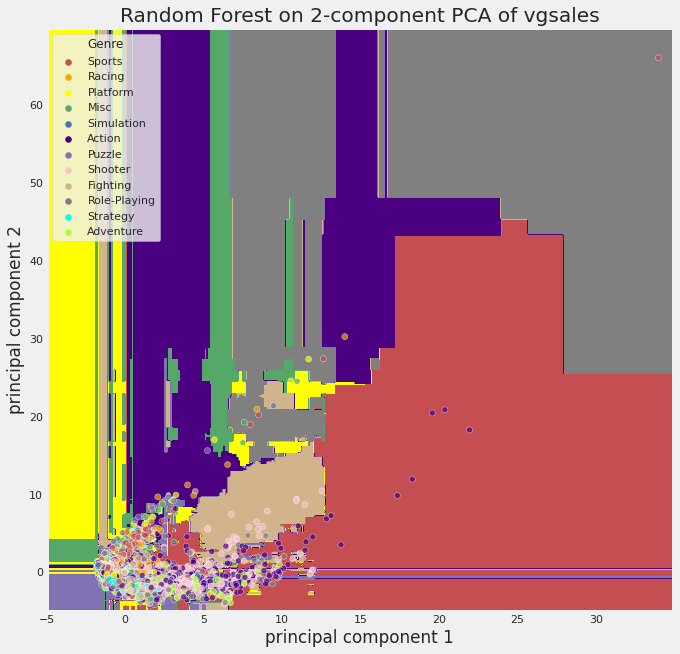

In [30]:
randomForest = RandomForestClassifier(random_state=24, max_depth = 10)
randomForest.fit(Xtrain, ytrain)
plt.figure(figsize=(10,10))
xx, yy = np.meshgrid(np.arange(-5, 35, 0.1), np.arange(-5, 70, 0.1))
Z_string = randomForest.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = ListedColormap(np.array(['r', 'orange', 'yellow', 'g', 'b', 'indigo', 'm', 'pink', 'tan', 'gray', 'cyan', 'greenyellow'])))
sns.scatterplot(data = finalfinalDf, x = 'principal component 1', y = 'principal component 2', hue = 'Genre', palette=['r', 'orange', 'yellow', 'g', 'b', 'indigo', 'm', 'pink', 'tan', 'gray', 'cyan', 'greenyellow'],alpha=0.7)
plt.title('Random Forest on 2-component PCA of vgsales');

In [31]:
vgsales_combined_encoded.columns

Index(['Rank', 'Name', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'Alcohol Reference',
       'Alcohol and Tobacco Reference', 'Animated Blood',
       'Animated Blood and Gore', 'Animated Violence', 'Blood',
       'Blood and Gore', 'Cartoon Violence', 'Comic Mischief', 'Crude Humor',
       'Drug Reference', 'Drug and Alcohol Reference', 'Edutainment',
       'Fantasy Violence', 'Gambling', 'Gaming', 'Informational',
       'Intense Violence', 'Language', 'Lyrics', 'Mature Humor',
       'Mature Sexual Themes', 'Mild Animated Violence', 'Mild Blood',
       'Mild Cartoon Violence', 'Mild Fantasy Violence', 'Mild Language',
       'Mild Lyrics', 'Mild Sexual Themes', 'Mild Suggestive Themes',
       'Mild Violence', 'No Descriptors', 'Nudity', 'Partial Nudity',
       'Realistic Blood', 'Realistic Blood and Gore', 'Realistic Violence',
       'Sexual Content', 'Sexual Themes', 'Sexual Violence',
       'Simulated Gambling', 

In [32]:
rawXdata = vgsales_combined_encoded[['NA_Sales', 'EU_Sales',
       'JP_Sales', 'Other_Sales', 'Global_Sales', 'Alcohol Reference',
       'Alcohol and Tobacco Reference', 'Animated Blood',
       'Animated Blood and Gore', 'Animated Violence', 'Blood',
       'Blood and Gore', 'Cartoon Violence', 'Comic Mischief', 'Crude Humor',
       'Drug Reference', 'Drug and Alcohol Reference', 'Edutainment',
       'Fantasy Violence', 'Gambling', 'Gaming', 'Informational',
       'Intense Violence', 'Language', 'Lyrics', 'Mature Humor',
       'Mature Sexual Themes', 'Mild Animated Violence', 'Mild Blood',
       'Mild Cartoon Violence', 'Mild Fantasy Violence', 'Mild Language',
       'Mild Lyrics', 'Mild Sexual Themes', 'Mild Suggestive Themes',
       'Mild Violence', 'No Descriptors', 'Nudity', 'Partial Nudity',
       'Realistic Blood', 'Realistic Blood and Gore', 'Realistic Violence',
       'Sexual Content', 'Sexual Themes', 'Sexual Violence',
       'Simulated Gambling', 'Strong Language', 'Strong Lyrics',
       'Strong Sexual Content', 'Suggestive Themes',
       'Suitable for Mature Users', 'Tobacco Reference', 'Use of Alcohol',
       'Use of Alcohol and Tobacco', 'Use of Drugs',
       'Use of Drugs and Alcohol', 'Use of Tobacco', 'Violence',
       'Violent References', 'Platform_DC', 'Platform_DS', 'Platform_GB',
       'Platform_GBA', 'Platform_GC', 'Platform_N64', 'Platform_NES',
       'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3',
       'Platform_PS4', 'Platform_PSP', 'Platform_PSV', 'Platform_SAT',
       'Platform_SNES', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne', 'ESRB_Rating_E', 'ESRB_Rating_E10plus',
       'ESRB_Rating_M', 'ESRB_Rating_T']]

Xtrain, Xtest, ytrain, ytest = train_test_split(
  rawXdata,vgsales_combined_encoded['Genre'],
  train_size = 0.75,
  random_state = 24)

In [33]:
accuracies = []
randomForests = [RandomForestClassifier(random_state=24, max_depth = i) for i in range(14, 19)]
for r in randomForests:
    accuracies.append(compute_CV_acc(r, Xtrain, ytrain))
best_max_depth = np.argmax(accuracies) + 14 # SOLUTION
best_acc = accuracies[np.argmax(accuracies)] # SOLUTION
print(best_max_depth, best_acc)

15 0.4406836461126005


In [34]:
# no depth limiting
randomForests = RandomForestClassifier(random_state=24)
randomForests.fit(Xtrain, ytrain)
randomForests.score(Xtest, ytest)

0.4492462311557789

In [35]:
# with depth limiting
randomForests = RandomForestClassifier(random_state=24, max_depth = 15)
randomForests.fit(Xtrain, ytrain)
randomForests.score(Xtest, ytest)

0.46733668341708545